# Phase 2: Feature Engineering
# NASA Turbofan Engine Degradation Dataset

**Objective:** Create 30-50 engineered features for baseline model

**Feature Categories:**
- Rolling statistics (mean, std, max, min) over multiple windows
- Lag features (previous cycle values)
- Rate of change (degradation velocity)
- Domain-specific features (stress indicators, anomaly detection)

**Target:** Improve predictive power for XGBoost + LSTM ensemble

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load Data & EDA Findings

In [2]:
# Load EDA findings
with open('../data/processed/eda_findings.json', 'r') as f:
    findings = json.load(f)

print("EDA Findings:")
print(f"  Top sensors: {findings['top_sensors'][:5]}")
print(f"  Total samples: {findings['total_samples']}")
print(f"  Class imbalance: {findings['class_imbalance_ratio']:.2f}:1")

top_sensors = findings['top_sensors'][:10]  # Focus on top 10 sensors
print(f"\n📊 Using {len(top_sensors)} top sensors for feature engineering")

EDA Findings:
  Top sensors: ['sensor_11', 'sensor_4', 'sensor_12', 'sensor_7', 'sensor_15']
  Total samples: 20631
  Class imbalance: 5.66:1

📊 Using 10 top sensors for feature engineering


In [3]:
# Load training data
columns = ['unit_id', 'cycle'] + \
          [f'op_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_{i}' for i in range(1, 22)]

data_path = Path('../turbofan_ed_dataset/train_FD001.txt')
df = pd.read_csv(data_path, sep='\s+', header=None, names=columns)

# Calculate RUL and target
df['RUL'] = df.groupby('unit_id')['cycle'].transform('max') - df['cycle']
df['failure_soon'] = (df['RUL'] <= 30).astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Engines: {df['unit_id'].nunique()}")
df.head()

Dataset shape: (20631, 28)
Engines: 100


,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,failure_soon
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


## 2. Rolling Statistics Features

Create rolling mean, std, max, min over multiple window sizes (5, 10, 25 cycles)

In [4]:
def create_rolling_features(df, sensors, windows=[5, 10, 25]):
    """
    Create rolling statistics for specified sensors.
    
    Args:
        df: DataFrame with sensor data
        sensors: List of sensor column names
        windows: List of window sizes
    
    Returns:
        DataFrame with rolling features
    """
    df_features = df.copy()
    
    for sensor in sensors:
        for window in windows:
            # Rolling mean
            df_features[f'{sensor}_roll_mean_{window}'] = df.groupby('unit_id')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
            
            # Rolling std
            df_features[f'{sensor}_roll_std_{window}'] = df.groupby('unit_id')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).std().fillna(0)
            )
            
            # Rolling max
            df_features[f'{sensor}_roll_max_{window}'] = df.groupby('unit_id')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).max()
            )
            
            # Rolling min
            df_features[f'{sensor}_roll_min_{window}'] = df.groupby('unit_id')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).min()
            )
    
    return df_features

print("Creating rolling features for top sensors...")
df_features = create_rolling_features(df, top_sensors[:5], windows=[5, 10, 25])  # Start with top 5 sensors

# Count new features
new_features = [col for col in df_features.columns if 'roll' in col]
print(f"✅ Created {len(new_features)} rolling features")
print(f"\nSample features: {new_features[:5]}")

Creating rolling features for top sensors...
✅ Created 60 rolling features

Sample features: ['sensor_11_roll_mean_5', 'sensor_11_roll_std_5', 'sensor_11_roll_max_5', 'sensor_11_roll_min_5', 'sensor_11_roll_mean_10']


## 3. Lag Features

Create lag features (previous cycle values) for detecting degradation trends

In [5]:
def create_lag_features(df, sensors, lags=[1, 3, 5]):
    """
    Create lag features for specified sensors.
    
    Args:
        df: DataFrame with sensor data
        sensors: List of sensor column names
        lags: List of lag periods
    
    Returns:
        DataFrame with lag features
    """
    df_features = df.copy()
    
    for sensor in sensors:
        for lag in lags:
            df_features[f'{sensor}_lag_{lag}'] = df.groupby('unit_id')[sensor].shift(lag).fillna(method='bfill')
    
    return df_features

print("Creating lag features...")
df_features = create_lag_features(df_features, top_sensors[:5], lags=[1, 3, 5])

lag_features = [col for col in df_features.columns if 'lag' in col]
print(f"✅ Created {len(lag_features)} lag features")
print(f"\nSample features: {lag_features[:5]}")

Creating lag features...
✅ Created 15 lag features

Sample features: ['sensor_11_lag_1', 'sensor_11_lag_3', 'sensor_11_lag_5', 'sensor_4_lag_1', 'sensor_4_lag_3']


## 4. Rate of Change Features

Calculate degradation velocity (how fast sensors are changing)

In [6]:
def create_rate_of_change_features(df, sensors):
    """
    Create rate of change features (sensor value differences).
    
    Args:
        df: DataFrame with sensor data
        sensors: List of sensor column names
    
    Returns:
        DataFrame with rate of change features
    """
    df_features = df.copy()
    
    for sensor in sensors:
        # First-order difference (velocity)
        df_features[f'{sensor}_diff_1'] = df.groupby('unit_id')[sensor].diff().fillna(0)
        
        # Second-order difference (acceleration)
        df_features[f'{sensor}_diff_2'] = df.groupby('unit_id')[sensor].diff().diff().fillna(0)
        
        # Cumulative sum (total change from start)
        df_features[f'{sensor}_cumsum'] = df.groupby('unit_id')[sensor].cumsum()
    
    return df_features

print("Creating rate of change features...")
df_features = create_rate_of_change_features(df_features, top_sensors[:5])

roc_features = [col for col in df_features.columns if ('diff' in col or 'cumsum' in col)]
print(f"✅ Created {len(roc_features)} rate of change features")
print(f"\nSample features: {roc_features[:5]}")

Creating rate of change features...
✅ Created 15 rate of change features

Sample features: ['sensor_11_diff_1', 'sensor_11_diff_2', 'sensor_11_cumsum', 'sensor_4_diff_1', 'sensor_4_diff_2']


## 5. Domain-Specific Features

Engineering domain features based on turbofan physics and degradation patterns

In [7]:
def create_domain_features(df):
    """
    Create domain-specific features for turbofan engines.
    
    Args:
        df: DataFrame with sensor data
    
    Returns:
        DataFrame with domain features
    """
    df_features = df.copy()
    
    # 1. Cycle-based features
    df_features['cycles_normalized'] = df.groupby('unit_id')['cycle'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    
    # 2. Multi-sensor interactions (stress indicators)
    df_features['temp_pressure_ratio'] = df['sensor_2'] / (df['sensor_3'] + 1e-6)
    df_features['vibration_temp_product'] = df['sensor_11'] * df['sensor_2']
    
    # 3. Anomaly indicators (distance from mean)
    for sensor in ['sensor_2', 'sensor_3', 'sensor_11']:
        sensor_mean = df.groupby('unit_id')[sensor].transform('mean')
        sensor_std = df.groupby('unit_id')[sensor].transform('std')
        df_features[f'{sensor}_zscore'] = (df[sensor] - sensor_mean) / (sensor_std + 1e-6)
    
    # 4. Operating condition changes
    for op_setting in ['op_setting_1', 'op_setting_2', 'op_setting_3']:
        df_features[f'{op_setting}_diff'] = df.groupby('unit_id')[op_setting].diff().fillna(0)
    
    # 5. Degradation stage (early, mid, late lifecycle)
    df_features['degradation_stage'] = pd.cut(
        df_features['cycles_normalized'], 
        bins=[0, 0.33, 0.66, 1.0], 
        labels=[0, 1, 2],
        include_lowest=True
    ).astype(int)
    
    return df_features

print("Creating domain-specific features...")
df_features = create_domain_features(df_features)

domain_features = ['cycles_normalized', 'temp_pressure_ratio', 'vibration_temp_product',
                   'sensor_2_zscore', 'sensor_3_zscore', 'sensor_11_zscore', 
                   'op_setting_1_diff', 'op_setting_2_diff', 'op_setting_3_diff',
                   'degradation_stage']
print(f"✅ Created {len(domain_features)} domain features")
print(f"\nFeatures: {domain_features}")

Creating domain-specific features...
✅ Created 10 domain features

Features: ['cycles_normalized', 'temp_pressure_ratio', 'vibration_temp_product', 'sensor_2_zscore', 'sensor_3_zscore', 'sensor_11_zscore', 'op_setting_1_diff', 'op_setting_2_diff', 'op_setting_3_diff', 'degradation_stage']


## 6. Feature Summary & Validation

In [8]:
# Count all engineered features
original_cols = set(df.columns)
engineered_features = [col for col in df_features.columns if col not in original_cols]

print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"\nOriginal features: {len(original_cols)}")
print(f"Engineered features: {len(engineered_features)}")
print(f"Total features: {len(df_features.columns)}")

print(f"\n📊 Feature Breakdown:")
print(f"  Rolling statistics: {len(new_features)}")
print(f"  Lag features: {len(lag_features)}")
print(f"  Rate of change: {len(roc_features)}")
print(f"  Domain features: {len(domain_features)}")

# Check for NaN or Inf
nan_count = df_features[engineered_features].isnull().sum().sum()
inf_count = np.isinf(df_features[engineered_features].select_dtypes(include=[np.number])).sum().sum()

print(f"\n✅ Data Quality:")
print(f"  NaN values: {nan_count}")
print(f"  Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("\n⚠️ Warning: Found NaN/Inf values. Cleaning...")
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    df_features = df_features.fillna(method='ffill').fillna(method='bfill').fillna(0)
    print("✅ Cleaned!")

FEATURE ENGINEERING SUMMARY

Original features: 28
Engineered features: 100
Total features: 128

📊 Feature Breakdown:
  Rolling statistics: 60
  Lag features: 15
  Rate of change: 15
  Domain features: 10

✅ Data Quality:
  NaN values: 0
  Inf values: 0


## 7. Feature Distribution Visualization

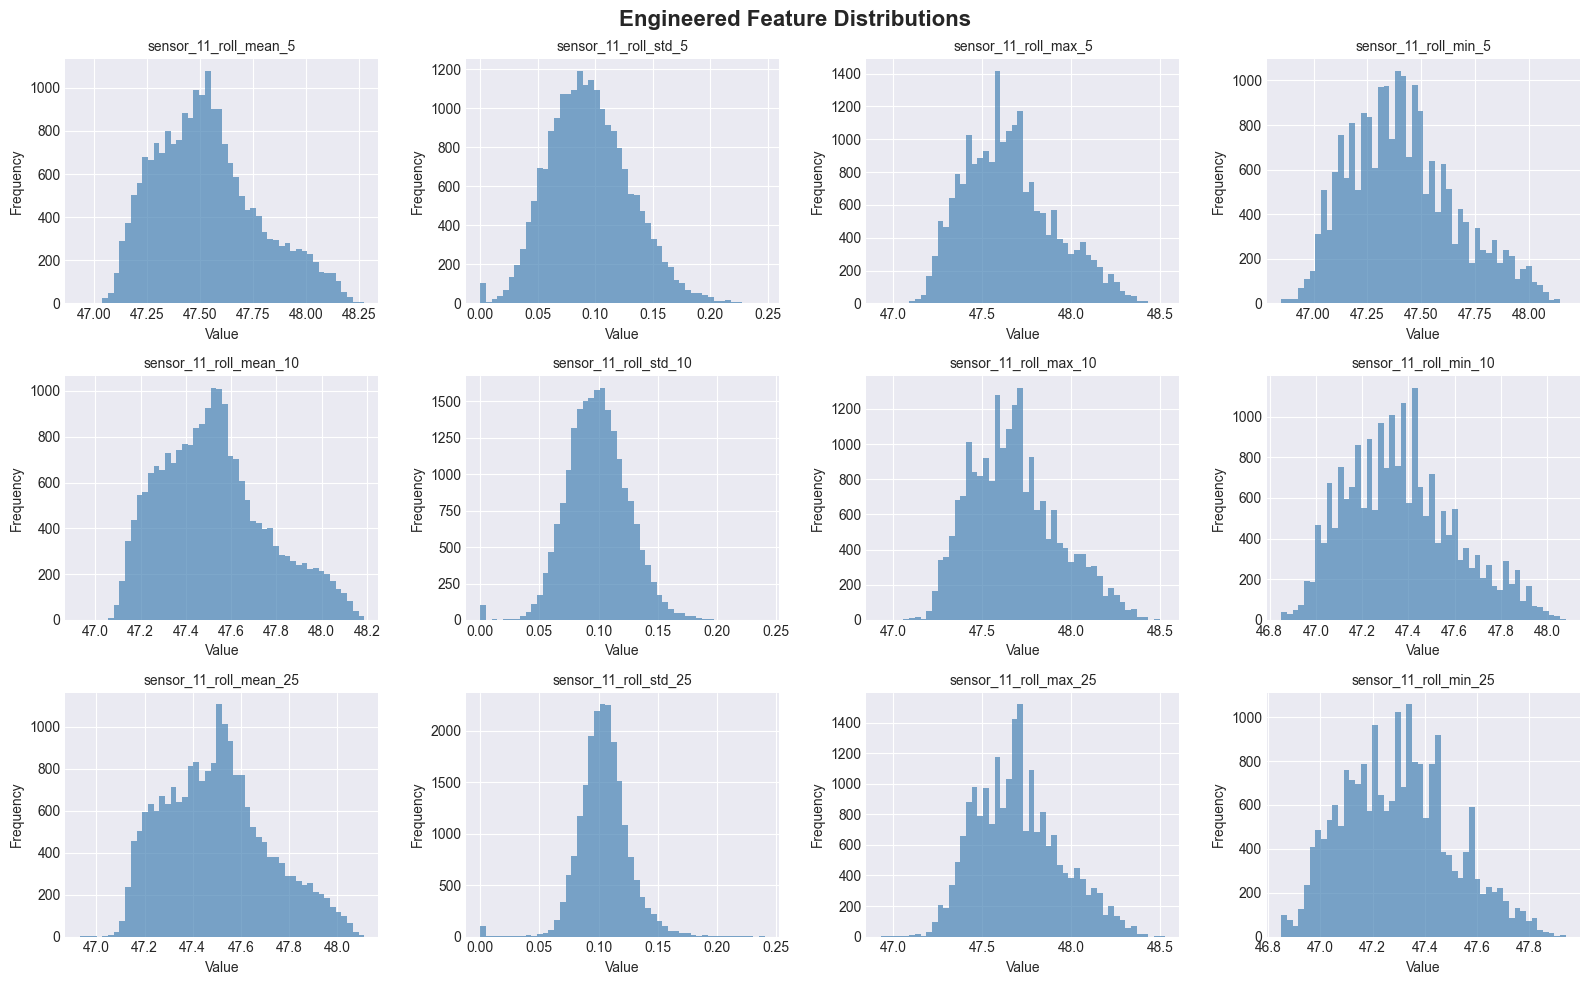

In [9]:
# Plot distributions of key engineered features
sample_features = engineered_features[:12]  # Show 12 features

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('Engineered Feature Distributions', fontsize=16, fontweight='bold')

for idx, feature in enumerate(sample_features):
    ax = axes[idx // 4, idx % 4]
    df_features[feature].hist(bins=50, ax=ax, color='steelblue', alpha=0.7)
    ax.set_title(feature, fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 8. Feature Correlation with Target

Top 15 Engineered Features by Correlation with Target:
sensor_11_zscore          0.735794
sensor_11_roll_mean_5     0.696717
sensor_4_roll_mean_5      0.695622
sensor_15_roll_mean_10    0.694918
sensor_15_roll_mean_5     0.693216
sensor_4_roll_mean_10     0.691860
sensor_11_roll_mean_10    0.690613
sensor_11_roll_max_5      0.682336
sensor_11_roll_min_5      0.681704
sensor_12_roll_mean_5     0.677270
sensor_4_roll_max_5       0.676849
sensor_4_roll_max_10      0.676738
sensor_11_roll_max_10     0.675685
vibration_temp_product    0.674703
sensor_7_roll_mean_5      0.674600
Name: failure_soon, dtype: float64


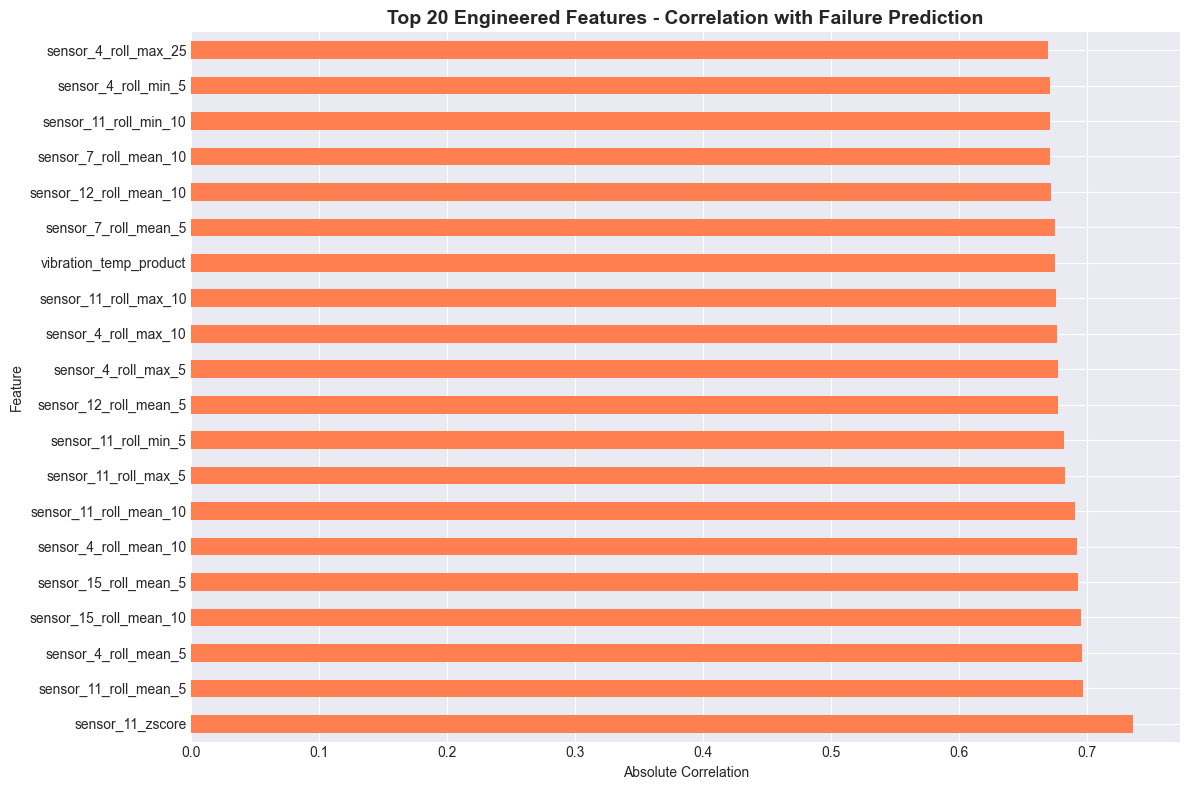

In [10]:
# Calculate correlation with failure_soon
feature_correlations = df_features[engineered_features + ['failure_soon']].corr()['failure_soon'].drop('failure_soon')
feature_correlations = feature_correlations.abs().sort_values(ascending=False)

print("Top 15 Engineered Features by Correlation with Target:")
print(feature_correlations.head(15))

# Plot top 20
plt.figure(figsize=(12, 8))
feature_correlations.head(20).plot(kind='barh', color='coral')
plt.title('Top 20 Engineered Features - Correlation with Failure Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 9. Save Engineered Features

In [11]:
# Save full dataset with features
output_path = Path('../data/processed/train_features_FD001.csv')
df_features.to_csv(output_path, index=False)
print(f"✅ Saved engineered features to: {output_path}")
print(f"   Shape: {df_features.shape}")

# Save feature metadata
feature_metadata = {
    'total_features': len(df_features.columns),
    'engineered_features': len(engineered_features),
    'feature_names': engineered_features,
    'top_15_correlations': feature_correlations.head(15).to_dict(),
    'rolling_windows': [5, 10, 25],
    'lag_periods': [1, 3, 5]
}

metadata_path = Path('../data/processed/feature_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"✅ Saved feature metadata to: {metadata_path}")

✅ Saved engineered features to: ..\data\processed\train_features_FD001.csv
   Shape: (20631, 128)
✅ Saved feature metadata to: ..\data\processed\feature_metadata.json
